In [ ]:
import pandas as pd


df = pd.read_csv('../data/application_record.csv')
df = df[['ID', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL']]


credit = pd.read_csv('../data/credit_record.csv')
behavior = credit.groupby('ID')['STATUS'].apply(lambda s: s.isin(['1', '2', '3', '4', '5']).sum()).reset_index()
behavior.columns = ['ID', 'overdue_months']


df = df.merge(behavior, on='ID', how='left')
df['overdue_months'] = df['overdue_months'].fillna(0)


def behavior_based_approval(row):
    return 1 if row['AMT_INCOME_TOTAL'] > 150000 and row['NAME_INCOME_TYPE'] == 'Working' and row['overdue_months'] <= 2 else 0


def biased_approval(row):
    bias_flag = 0
    if row['CODE_GENDER'] == 'F':
        bias_flag += 1
    if row['NAME_FAMILY_STATUS'] == 'Single / not married':
        bias_flag += 1
    return 1 if row['AMT_INCOME_TOTAL'] > 150000 and row['NAME_INCOME_TYPE'] == 'Working' and bias_flag == 0 else 0


df['approved_behavior'] = df.apply(behavior_based_approval, axis=1)
df['approved_biased'] = df.apply(biased_approval, axis=1)
df['bias_wrong'] = (df['approved_behavior'] == 1) & (df['approved_biased'] == 0)


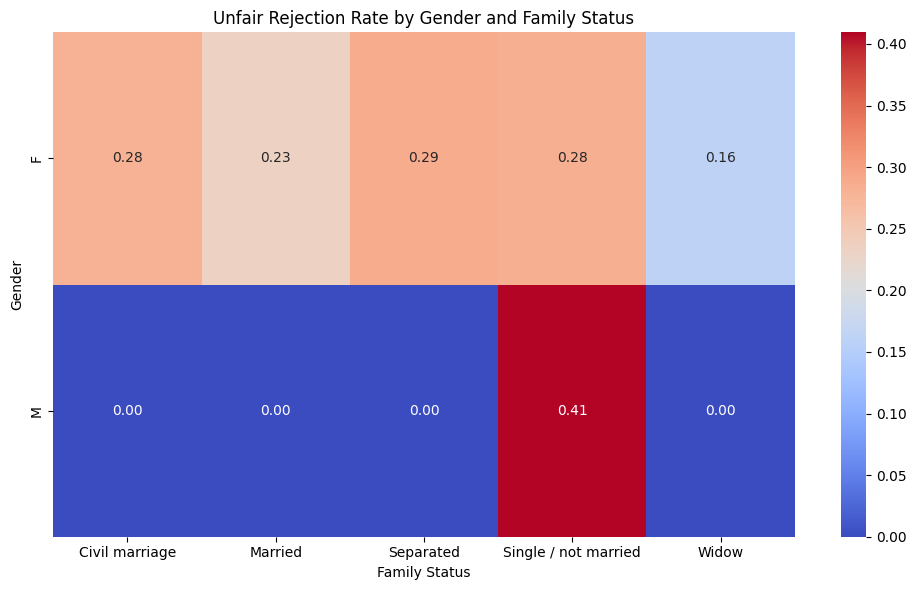

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


heatmap_data = df.pivot_table(index='CODE_GENDER', columns='NAME_FAMILY_STATUS', values='bias_wrong', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Unfair Rejection Rate by Gender and Family Status')
plt.xlabel('Family Status')
plt.ylabel('Gender')
plt.tight_layout()
plt.show()
